Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

Set random seed for reproducibility

In [2]:
np.random.seed(42)

Load the dataset

In [3]:
df = pd.read_excel('NASDAQ Historical Prices.xlsx')

Convert Date column to datetime and set as index

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

## 1. Data Understanding and Preprocessing

### Exploratory Data Analysis (EDA)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2577 entries, 2014-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2577 non-null   float64
 1   High       2577 non-null   float64
 2   Low        2577 non-null   float64
 3   Close      2577 non-null   float64
 4   Adj Close  2577 non-null   float64
 5   Volume     2577 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.9 KB
None

Descriptive Statistics:
               Open          High           Low         Close     Adj Close  \
count   2577.000000   2577.000000   2577.000000   2577.000000   2577.000000   
mean    8732.694091   8791.205699   8668.731742   8734.262208   8734.262208   
std     3677.687970   3706.549415   3645.039075   3677.801153   3677.801153   
min     4015.070068   4026.280029   3946.030029   3996.959961   3996.959961   
25%     5147.870117   5167.540039   5122.779785   5153.580078   5

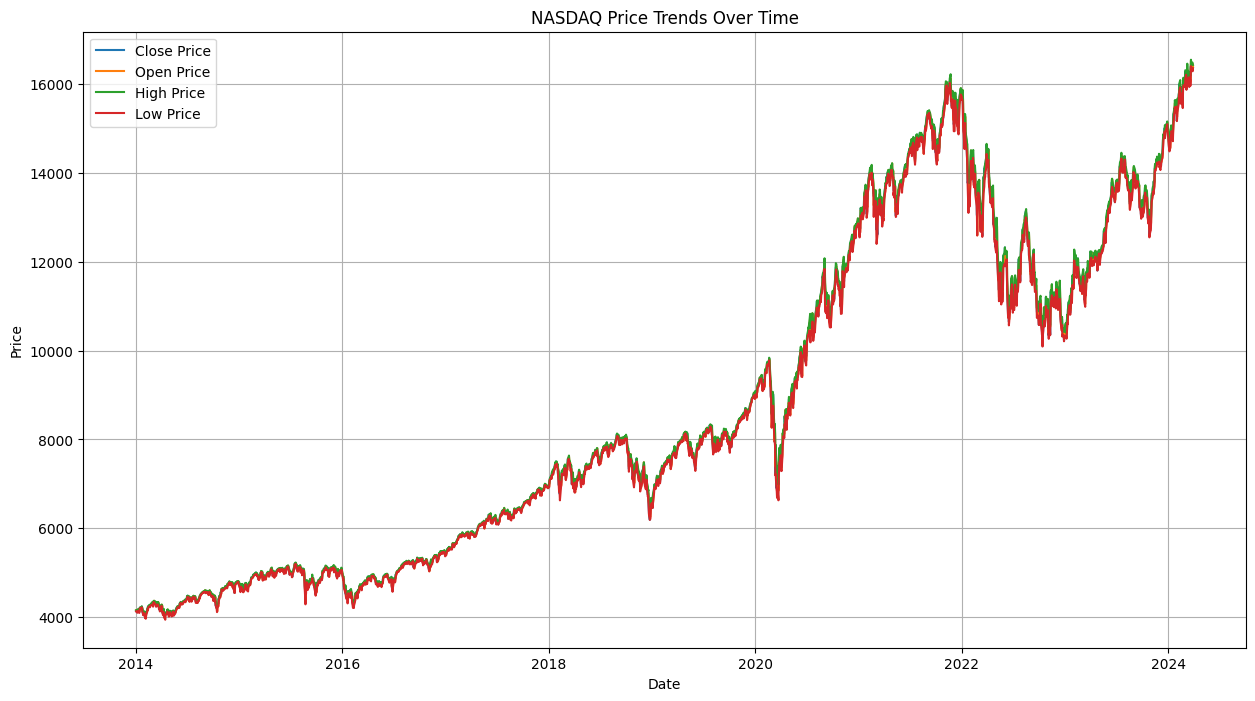

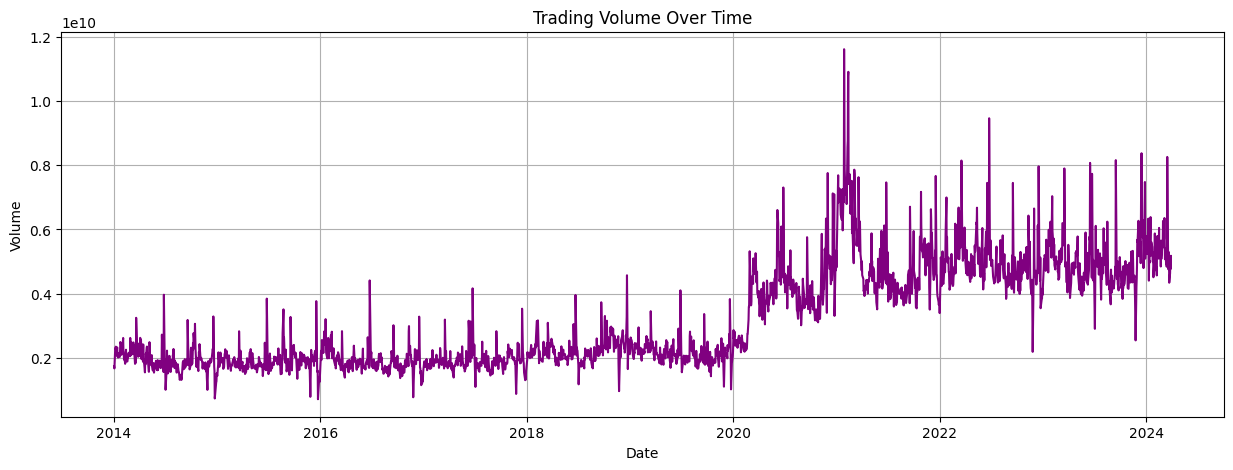

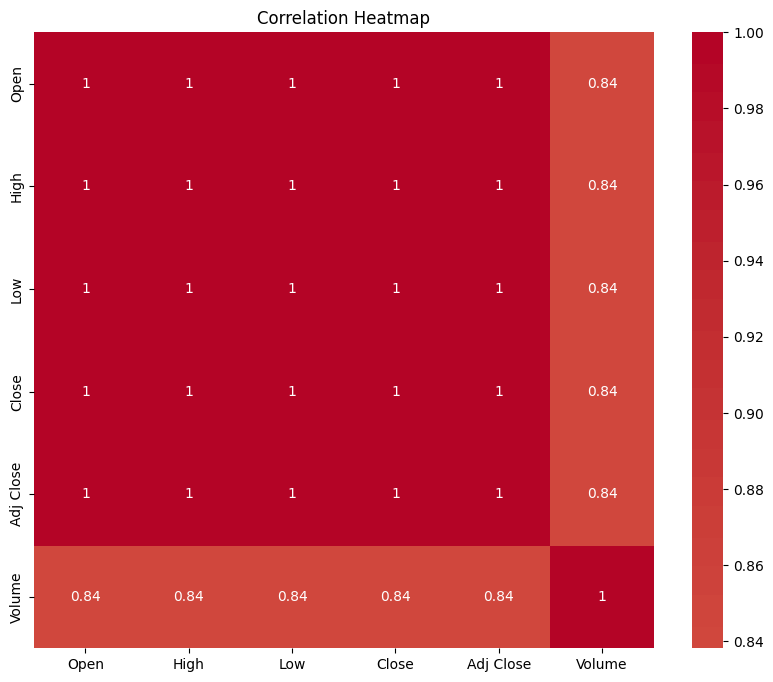

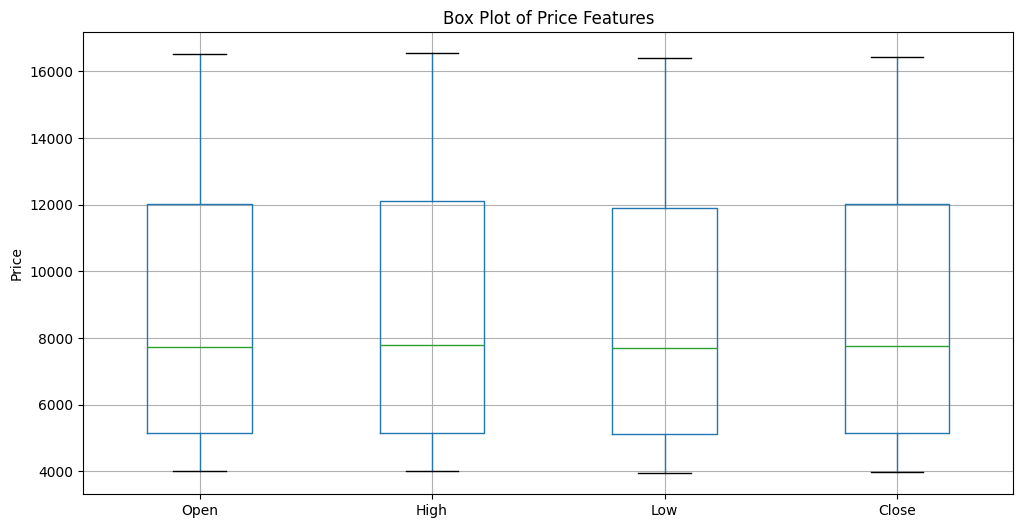

In [8]:
def perform_eda(df):
    print("Dataset Info:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())

    # Plot price trends
    plt.figure(figsize=(15, 8))
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Open'], label='Open Price')
    plt.plot(df['High'], label='High Price')
    plt.plot(df['Low'], label='Low Price')
    plt.title('NASDAQ Price Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot volume trends
    plt.figure(figsize=(15, 5))
    plt.plot(df['Volume'], label='Trading Volume', color='purple')
    plt.title('Trading Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()

    # Box plots for outlier detection
    plt.figure(figsize=(12, 6))
    df[['Open', 'High', 'Low', 'Close']].boxplot()
    plt.title('Box Plot of Price Features')
    plt.ylabel('Price')
    plt.show()

perform_eda(df)


### Handling Missing Values

In [9]:
def handle_missing_values(df):
    print("\nMissing Values Before Treatment:")
    print(df.isnull().sum())

    # Forward fill for price data, as stock prices typically don't change on non-trading days
    df[['Open', 'High', 'Low', 'Close', 'Adj Close']] = df[['Open', 'High', 'Low', 'Close', 'Adj Close']].fillna(method='ffill')

    # For volume, we'll fill with 0 (assuming no trading occurred)
    df['Volume'] = df['Volume'].fillna(0)

    print("\nMissing Values After Treatment:")
    print(df.isnull().sum())
    return df

df = handle_missing_values(df)



Missing Values Before Treatment:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing Values After Treatment:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Outlier Detection and Treatment

In [10]:
def handle_outliers(df):
    # Calculate Z-scores for price columns
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    z_scores = (df[price_cols] - df[price_cols].mean()) / df[price_cols].std()

    # Identify outliers (Z-score > 3 or < -3)
    outliers = (z_scores > 3) | (z_scores < -3)
    print(f"\nNumber of outliers detected: {outliers.sum().sum()}")

    # Instead of removing, we'll cap the outliers
    for col in price_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        df[col] = np.where(df[col] < lower_bound, lower_bound,
                          np.where(df[col] > upper_bound, upper_bound, df[col]))

    return df

df = handle_outliers(df)



Number of outliers detected: 0


### Data Scaling and Normalization

In [12]:
def scale_data(df):
    # We'll use MinMax scaling for neural networks (better for LSTM)
    price_scaler = MinMaxScaler(feature_range=(0, 1))
    volume_scaler = MinMaxScaler(feature_range=(0, 1))

    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df[price_cols] = price_scaler.fit_transform(df[price_cols])

    # Volume needs separate scaling due to different scale
    df['Volume'] = volume_scaler.fit_transform(df[['Volume']])

    return df, price_scaler, volume_scaler

df, price_scaler, volume_scaler = scale_data(df)


### Data Splitting

In [13]:
def split_data(df, test_size=0.2):
    # For time series, we split sequentially (not randomly)
    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]

    print(f"\nTraining set size: {len(train)}")
    print(f"Test set size: {len(test)}")

    return train, test

train, test = split_data(df)


Training set size: 2061
Test set size: 516


## 2. Feature Engineering

### Time-Based Features

In [15]:
def add_time_features(df):
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # Add trading day indicator (1 for trading day, 0 for weekend/holiday)
    # Note: This dataset appears to only contain trading days
    df['trading_day'] = 1  # All days in this dataset are trading days

    return df

train = add_time_features(train)
test = add_time_features(test)


### Rolling Averages and Moving Windows

In [16]:
def add_rolling_features(df, window_sizes=[5, 10, 20]):
    for window in window_sizes:
        df[f'rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['Close'].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df['Close'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['Close'].rolling(window=window).max()

    # Exponential moving averages
    df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()

    # MACD (Moving Average Convergence Divergence)
    df['macd'] = df['ema_12'] - df['ema_26']

    return df

train = add_rolling_features(train)
test = add_rolling_features(test)

### Lagged Features

In [18]:
def add_lagged_features(df, lags=[1, 2, 3, 5, 10]):
    for lag in lags:
        df[f'lag_{lag}'] = df['Close'].shift(lag)

    return df

train = add_lagged_features(train)
test = add_lagged_features(test)


### Interaction Features

In [20]:
def add_interaction_features(df):
    # Price volatility (daily range)
    df['daily_range'] = df['High'] - df['Low']

    # Price-volume interaction
    df['price_volume'] = df['Close'] * df['Volume']

    # Normalized daily range
    df['norm_range'] = (df['High'] - df['Low']) / df['Close']

    return df

train = add_interaction_features(train)
test = add_interaction_features(test)


### Feature Selection

In [22]:
def select_features(train, test):
    # Drop rows with NaN values created by rolling/lag features
    train_clean = train.dropna()
    test_clean = test.dropna()

    # Select features - we'll use all engineered features for now
    # In practice, you might use feature importance or correlation analysis
    features = [col for col in train_clean.columns if col not in ['Close', 'Adj Close']]
    target = 'Close'

    X_train = train_clean[features]
    y_train = train_clean[target]
    X_test = test_clean[features]
    y_test = test_clean[target]

    return X_train, y_train, X_test, y_test, features

X_train, y_train, X_test, y_test, features = select_features(train, test)

In [38]:
def add_interaction_features(df):
    # Price volatility (daily range)
    df['daily_range'] = df['High'] - df['Low']

    # Price-volume interaction
    df['price_volume'] = df['Close'] * df['Volume']

    # Normalized daily range
    # Replace with 0 if close price is 0
    df['norm_range'] = np.where(df['Close'] != 0, (df['High'] - df['Low']) / df['Close'], 0)

    r

## 3. Model Development


### Baseline Models

In [39]:
# Replace inf/-inf with NaN and drop rows with NaNs
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Drop any rows that still contain NaNs
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]


Linear Regression Performance:
MSE: 0.000014
MAE: 0.002931
RMSE: 0.003780

Random Forest Performance:
MSE: 0.000139
MAE: 0.008230
RMSE: 0.011801


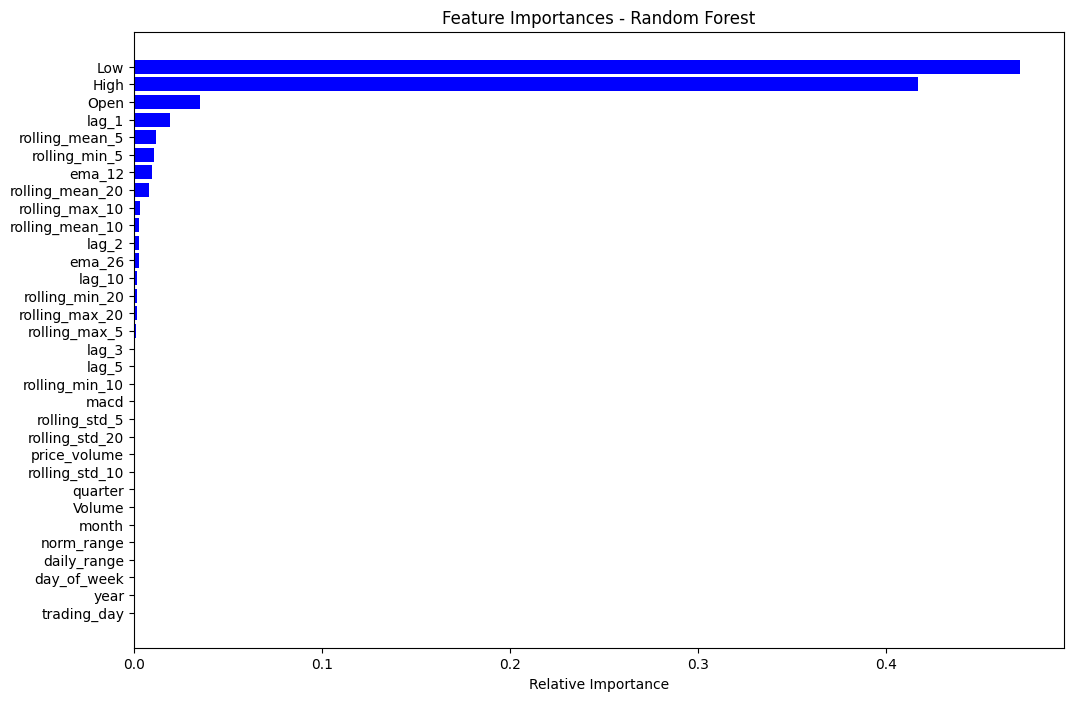

In [40]:
def evaluate_baseline_models(X_train, y_train, X_test, y_test):
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    # Calculate metrics
    def calculate_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        print(f"\n{model_name} Performance:")
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"RMSE: {rmse:.6f}")

        return mse, mae, rmse

    lr_metrics = calculate_metrics(y_test, lr_pred, "Linear Regression")
    rf_metrics = calculate_metrics(y_test, rf_pred, "Random Forest")
 # Plot feature importance
    plt.figure(figsize=(12, 8))
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title('Feature Importances - Random Forest')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()
    plt.show()

    return lr_metrics, rf_metrics

lr_metrics, rf_metrics = evaluate_baseline_models(X_train, y_train, X_test, y_test)

### Deep Learning Model Design

In [41]:
def prepare_lstm_data(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

time_steps = 30
X_train_lstm, y_train_lstm = prepare_lstm_data(X_train, y_train, time_steps)
X_test_lstm, y_test_lstm = prepare_lstm_data(X_test, y_test, time_steps)

def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=units, return_sequences=True,
                  input_shape=input_shape,
                  kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))

    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True,
                 kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))

    # Third LSTM layer
    model.add(LSTM(units=units,
                 kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = build_lstm_model(input_shape)

## 4. Model Training and Evaluation

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 1.7877 - mae: 0.2411 - val_loss: 0.8267 - val_mae: 0.3742
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.5812 - mae: 0.2110 - val_loss: 0.3734 - val_mae: 0.3974
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2268 - mae: 0.2091 - val_loss: 0.2612 - val_mae: 0.4161
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1359 - mae: 0.2208 - val_loss: 0.2461 - val_mae: 0.4417
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1013 - mae: 0.2117 - val_loss: 0.2031 - val_mae: 0.4079
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0933 - mae: 0.2169 - val_loss: 0.2039 - val_mae: 0.4179
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0840 - mae: 0.2130 - val_loss: 0.1787 - val_mae: 0.3923
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0804 - mae: 0.2145 - val_loss: 0.1831 - val_mae: 0.4016
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - l

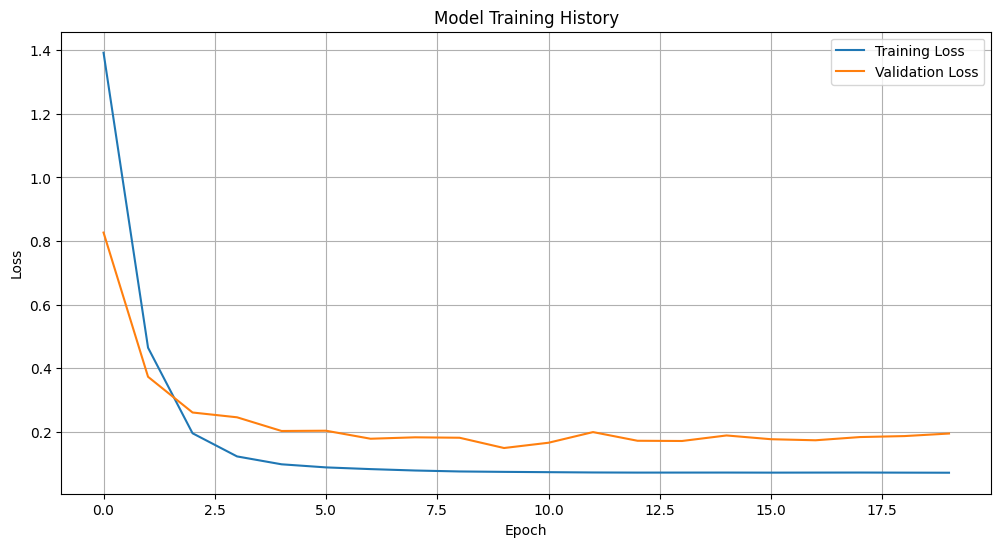


Test MSE: 0.149532
Test MAE: 0.361473
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Test RMSE: 0.384269


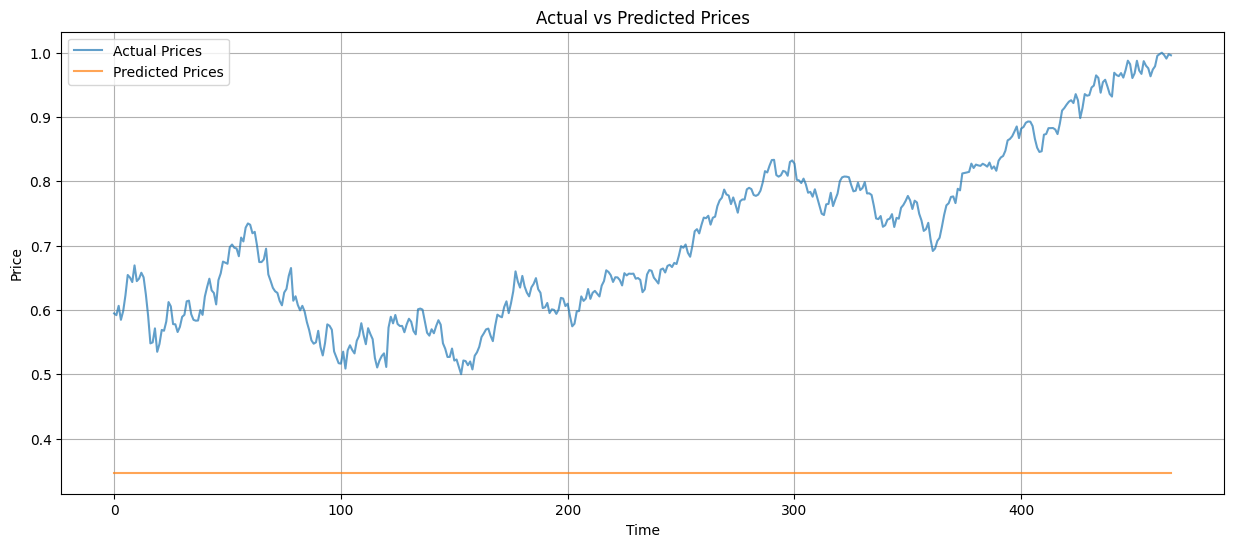

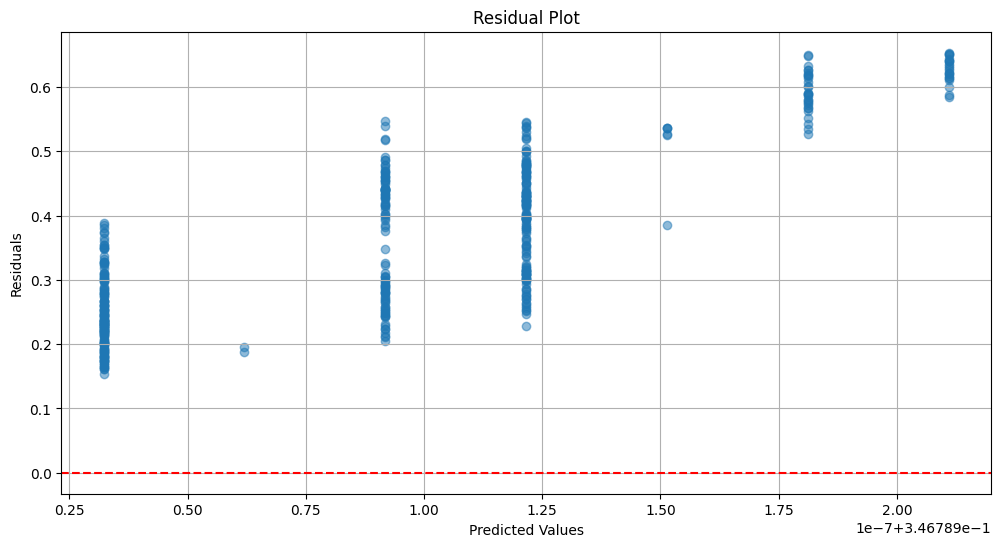

In [42]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest MSE: {test_loss:.6f}")
    print(f"Test MAE: {test_mae:.6f}")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE: {rmse:.6f}")

    # Plot predictions vs actual
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Prices', alpha=0.7)
    plt.plot(y_pred, label='Predicted Prices', alpha=0.7)
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Residual plot
    residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(12, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

    return test_loss, test_mae, rmse

lstm_metrics = train_and_evaluate_model(lstm_model, X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

## 5. Model Optimization

In [43]:
def optimize_model(X_train, y_train, X_test, y_test):
    # Try different architectures
    models = []

    # Model 1: Simpler LSTM
    model1 = Sequential()
    model1.add(LSTM(50, input_shape=input_shape))
    model1.add(Dense(1))
    model1.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    models.append(('Simple LSTM', model1))

    # Model 2: GRU model
    model2 = Sequential()
    model2.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model2.add(GRU(50))
    model2.add(Dense(1))
    model2.compile(optimizer=RMSprop(0.001), loss='mse', metrics=['mae'])
    models.append(('GRU Model', model2))

    # Model 3: Deeper LSTM with more regularization
    model3 = Sequential()
    model3.add(LSTM(64, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l2(0.01)))
    model3.add(Dropout(0.3))
    model3.add(LSTM(32, kernel_regularizer=l2(0.01)))
    model3.add(Dropout(0.3))
    model3.add(Dense(1))
    model3.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])
    models.append(('Deeper LSTM', model3))

    # Evaluate all models
    results = []
    for name, model in models:
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train, epochs=50, batch_size=32,
                 validation_data=(X_test, y_test), verbose=0)

        loss, mae = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append((name, loss, mae, rmse))

        print(f"{name} Results:")
        print(f"MSE: {loss:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"RMSE: {rmse:.6f}")

    # Select best model
    best_model_info = min(results, key=lambda x: x[1])  # min MSE
    print(f"\nBest model: {best_model_info[0]} with MSE: {best_model_info[1]:.6f}")

    return best_model_info

best_model_info = optimize_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)



Training Simple LSTM...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Simple LSTM Results:
MSE: 0.185147
MAE: 0.410058
RMSE: 0.430287

Training GRU Model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
GRU Model Results:
MSE: 0.151199
MAE: 0.366332
RMSE: 0.388844

Training Deeper LSTM...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Deeper LSTM Results:
MSE: 0.010078
MAE: 0.057842
RMSE: 0.071125

Best model: Deeper LSTM with MSE: 0.010078


# Final comparison

In [44]:

print("\nFinal Model Comparison:")
print(f"{'Model':<20} {'MSE':<10} {'MAE':<10} {'RMSE':<10}")
print("-" * 50)
print(f"{'Linear Regression':<20} {lr_metrics[0]:<10.6f} {lr_metrics[1]:<10.6f} {lr_metrics[2]:<10.6f}")
print(f"{'Random Forest':<20} {rf_metrics[0]:<10.6f} {rf_metrics[1]:<10.6f} {rf_metrics[2]:<10.6f}")
print(f"{'Initial LSTM':<20} {lstm_metrics[0]:<10.6f} {lstm_metrics[1]:<10.6f} {lstm_metrics[2]:<10.6f}")
print(f"{best_model_info[0]:<20} {best_model_info[1]:<10.6f} {best_model_info[2]:<10.6f} {best_model_info[3]:<10.6f}")


Final Model Comparison:
Model                MSE        MAE        RMSE      
--------------------------------------------------
Linear Regression    0.000014   0.002931   0.003780  
Random Forest        0.000139   0.008230   0.011801  
Initial LSTM         0.149532   0.361473   0.384269  
Deeper LSTM          0.010078   0.057842   0.071125  
